# Sentiment-140 Classification

In this notebook, we will explore the application of transformers for sentiment analysis of different tweets. Our goal is to classify tweets to have either positive or negative sentiment. We will first consider the performance of a pre-trained BERT model, finetuned on the Sentiment-140 dataset, and later we'll develop and train our own transformer architecture from scratch. Let's dive right in!

First of all, we need a couple of useful libraries that you're hopefully familiar with.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from data_utils.SentimentDataset import SentimentDataset

# this automatically reloads the libraries so you can update them dynamically
%load_ext autoreload
%autoreload 2

## Loading our data

Let's start by preparing our dataset. We have implemented the dataset class for you in `data_utils/SentimentDataset.py`, feel free to check the implementation. However, before we can use the `SentimentDataset` class to create our train data and test data objects, we need to pre-process the raw data. 

You can download raw data from [here](https://www.kaggle.com/datasets/kazanova/sentiment140). If you examine the raw data file, you can see that there is a lot of redundant information such as the time of each tweet or usernames. For our sentiment analysis, we simply need the tweets and ground truth labels. To preprocess the data file, simply paste the original CSV file in the root project directory without changing the file name and run the script `preprocess_dataset.py`. This should create a new CSV file called `dataset.csv`. (The reason why we do not include the data files on the GitHub repository is that they are simply too big.) Then, you're ready to create a dataset and dataloader below.

Notice that the original dataset contains 1.6 million tweets; that is huge! Therefore, it may take forever to train on so much data, especially if you happen not to have access to a fast GPU (talk to the officers about getting access to the ACM AI server!). Therefore, in the next cell you can configure whether to use the whole dataset or just a subset of it.

In [2]:
use_subset_of_data = True
subset_percentage = 0.05 # set the percentage of original dataset size you'd like to use

In [3]:
train_data = SentimentDataset('dataset.csv', training_set=True)
test_data = SentimentDataset('dataset.csv', training_set=False)

if use_subset_of_data:
    train_set_len = int(subset_percentage * len(train_data))
    test_set_len = int(subset_percentage * len(test_data))
    
    train_subset_indices = np.random.choice(len(train_data), size=train_set_len, replace=False)
    train_sampler = SubsetRandomSampler(train_subset_indices)

    test_subset_indices = np.random.choice(len(test_data), size=test_set_len, replace=False)
    test_sampler = SubsetRandomSampler(test_subset_indices)

    train_loader = DataLoader(train_data, batch_size=32, sampler=train_sampler)
    test_loader = DataLoader(test_data, batch_size=32, sampler=test_sampler)

else:
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Let's examine a sample tweet from the dataset and print its corresponding ground truth label. Label 1 corresponds to positive sentiment, while label 0 stands for negative sentiment. You can run the cell below multiple times to see different tweets.

In [4]:
tweets, labels = next(iter(train_loader))
print("Sample tweet: ", tweets[0])
print("Ground truth label: ", labels[0].numpy())

Sample tweet:  I think I'm getting sick!!  NOOooo!!
Ground truth label:  0


## Fine-tuning BERT

First, let's examine the performance of a pre-trained BERT model on the sentiment analysis task. BERT (original paper [here](https://arxiv.org/abs/1810.04805)) is a language representation model released by Google in 2018 that uses a Bidirectional Transformer architecture.

It can be easily fine-tuned on downstream tasks such as sentiment analysis by appending a classification layer to the original BERT architecture. This is already done automatically by importing the `BertForSequenceClassification` from the Hugging Face library called `transformers`. The newly added classification layer is untrained (as you'll see in the warning that appears when you run the following cell) and so we have to fine-tune on the Sentiment-140 data. We will also import a pre-trained tokenizer, which is necessary to convert inputs from natural language to a numerical representation machine learning models can understand. The tokenizer imported from Hugging Face uses WordPiece tokenization, you can learn more about the algorithm [here](https://huggingface.co/learn/nlp-course/en/chapter6/6).

In [27]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name) 
pretrained_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Below, we define a `preprocess` function that takes in the tweets and tokenizes them. The tokenizer will break down words into smaller units called subword tokens and map these words to numbers (IDs), which can be processed by the model. Furthermore, it will add special tokens to the sequence that will normalize inputs to the model.

The `preprocess` function return `input_ids` which represents the tokenized input sequence and `attention_mask` which specifies to the model which tokens to attend to while computing self-attention (more on that later!).

In [28]:
def preprocess(tweets):

    encoded_batch = tokenizer.batch_encode_plus(
        tweets,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoded_batch['input_ids']
    attention_masks = encoded_batch['attention_mask']

    return input_ids, attention_masks

There are three different types of special tokens normally used by the BERT tokenizer. `[CLS]` token is added at the beginning of the input sequence. The final hidden state corresponding to the `[CLS]` token is typically used as the representation of the entire input sequence for classification tasks, so it will be very useful to us later for sentiment analysis. The `[SEP]` token is used to separate different segments of the input sequence. It helps the model distinguish between different parts of the input and process them accordingly. In our case, one `[SEP]` token will typically be added at the end of the tokenized input sequence (tweet). Finally, the `[PAD]` token is used for padding shorter input sequences to a fixed length, so that they can be easily processed in batches without any shape mismatch issues. With BERT, we would typically pad the input sequence to reach a total length of 512 tokens; however, since we're analyzing tweets that are by definition very short, using maximum sequence length of 128 tokens should suffice.

Below, you can see what the IDs reserved for special tokens are.

In [29]:
cls_token_id = tokenizer.cls_token_id
sep_token_id = tokenizer.sep_token_id
pad_token_id = tokenizer.pad_token_id

print("[CLS] Token ID: " + str(cls_token_id) + ", [SEP] Token ID: " + str(sep_token_id) + ", [PAD] Token ID: " + str(pad_token_id))

[CLS] Token ID: 101, [SEP] Token ID: 102, [PAD] Token ID: 0


We can print a sample tweet and its corresponding tokenized representation. Notice that each input sequence starts with token ID 101 (CLS token), ends with token ID 102 (SEP token), and is padded with token ID 0 (PAD token).

In [30]:
tweets, labels = next(iter(train_loader))
print("Sample tweet: ", tweets[0], '\n')
input_ids, att_masks = preprocess(tweets)
print("Tokenized representation: ", input_ids[0])

Sample tweet:  I wanna hug elmo. How comes @johnmayer gets to hug elmo. It's not fair. The world is no fair  

Tokenized representation:  tensor([  101,  1045, 10587,  8549, 17709,  2080,  1012,  2129,  3310,  1030,
         2198, 27871,  2121,  4152,  2000,  8549, 17709,  2080,  1012,  2009,
         1005,  1055,  2025,  4189,  1012,  1996,  2088,  2003,  2053,  4189,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
    

Next, we need to define a training and evaluation loop. Notice that we use the `preprocess` function in both the `train` and `evaluate` to transform the natural language input to tokenized representation. We will also collect loss and accuracy statistics during training, so that we can plot the training history later.

Note that the `finetuning` parameter is used simply because the internal Hugging Face representation of the pre-trained model is slightly different from what our representation will be when we later define our own transformer model. Thus, when using the training loop for fine-tuning the pre-trained downloaded from Hugging Face, set `finetuning=True`, otherwise set it to `False`.

In [31]:
def train(model, train_loader, val_loader, optimizer, criterion, device,
          num_epochs, finetuning=False):

    # Place model on device
    model = model.to(device)

    loss_history = []
    acc_history = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader),
                  desc=f'Epoch {epoch + 1}/{num_epochs}',
                  position=0,
                  leave=True) as pbar:
            
            for inputs, labels in train_loader:

                input_ids, attention_masks = preprocess(inputs)
                # Move inputs and labels to device
                input_ids = input_ids.to(device)
                attention_masks = attention_masks.to(device)
                labels = labels.to(device)

                # Zero out gradients
                optimizer.zero_grad()

                # Compute the logits and loss
                outputs = model(input_ids=input_ids, attention_mask=attention_masks)
                if finetuning: 
                    outputs = outputs.logits
                loss = criterion(outputs, labels)

                # Backpropagate the loss
                loss.backward()

                # Update the weights
                optimizer.step()

                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

                loss_history.append(loss.item())

                    
        avg_loss, accuracy = evaluate(model, val_loader, criterion, device, finetuning)
        print(
            f'Test set: Average loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}'
        )
        acc_history.append(accuracy)

    return loss_history, acc_history


def evaluate(model, test_loader, criterion, device, finetuning=False):

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        total_loss = 0.0
        num_correct = 0
        num_samples = 0

        for inputs, labels in test_loader:

            input_ids, attention_masks = preprocess(inputs)
            # Move inputs and labels to device
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            labels = labels.to(device)

            # Compute the logits and loss
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            if finetuning:
                outputs = outputs.logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Compute the accuracy
            _, predictions = torch.max(outputs, dim=1)
            num_correct += (predictions == labels).sum().item()
            num_samples += len(labels)

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    accuracy = num_correct / num_samples

    return avg_loss, accuracy

Make sure you are running the model on CUDA.

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


We will finetune all the weights in the BERT model (including the pre-trained weights and the newly initialized classifier weights). An alternative approach would be to freeze the pre-trained weights and only fine-tune the classifier weights. You can do that by passing in `model.classifier.parameters()` to the optimizer instead of passing in all the weights of the model.

In [33]:
optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

loss_history, acc_history = train(pretrained_model, train_loader, test_loader, optimizer, criterion, device, num_epochs=1, finetuning=True)

# Let's save our trained weights
torch.save(pretrained_model.state_dict(), 'bert_fine_tuned.pt')

Epoch 1/1:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 1/1: 100%|██████████| 2000/2000 [04:58<00:00,  6.70it/s, loss=0.213]


Test set: Average loss = 0.3693, Accuracy = 0.8346


Next, let's plot our training loss and test accuracy history that documents the fine-tuning process.

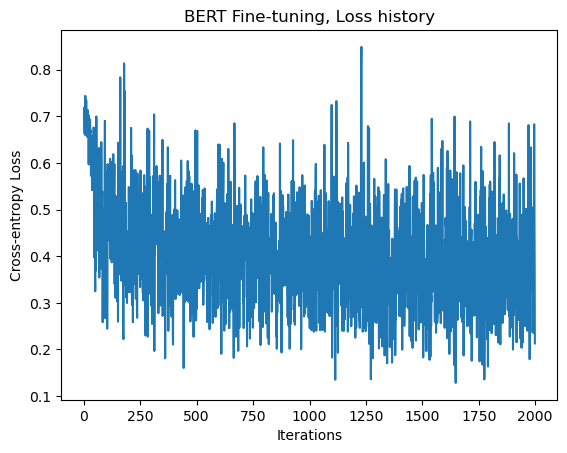

In [34]:
plt.plot(loss_history)
plt.xlabel('Iterations')
plt.ylabel('Cross-entropy Loss')
plt.title('BERT Fine-tuning, Loss history')
plt.show()

## Creating our own Transformer architecture from scratch

That was fun, right? But maybe slightly too easy, don't you think? Let's try to implement our own transformer architecture now, without the help of pre-trained models. We will base our architecture off of BERT, which will also allow us to effectively compare the performance of our own implementation with the pre-trained model. The high-level of the model architecture can be seen below.

Note that, compared to illustration below, all the tensor sizes will most likely be different and specific to the hyperparameters of our model.

![BERT For Sequence Classification](bert_classification.png)

![BERT Encoder](bert_encoder.png)

Let's first define some hyperparameters of our network. 

In [14]:
max_seq_length = 128 # Maximum length of tokenized input sequence (we already covered this above!)
vocab_size = 30522 # number of different token -> ID mappings, specific to the BERT Tokenizer
n_layers = 12 # number of transformer layers stacked on top of each other
n_heads = 12 # number of heads of the transformer, input sequence will be split and equally distributed to each head
emb_size = 768 # refers to the dimensionality of the vector representations used to encode input tokens
intermediate_size = emb_size * 4 # dimensionality of output of the Intermediate layer
dropout = 0.1 # probability of dropping a neuron during training
n_classes = 2 # we are classifying the sentiment of each tweet simply as POSITIVE or NEGATIVE
layer_norm_eps = 1e-12 # value used in Layer Norm for numerical stability

Below we will define the Embedding Layer. Embeddings are dense vector representations of tokens that allow us to position them in a high-dimensional vector space. These vector representations serve as coordinates for the tokens, enabling the model to capture their semantic relationships. The key idea is that tokens with similar meanings should be located closer together in the vector space, while tokens with dissimilar meanings should be farther apart.

For each token, we will generate two types of embeddings, which are then combined:

Word Embeddings: Vector representations of the tokens themselves, obtained from a lookup table with one row per token in the vocabulary.
Positional Embeddings: These embeddings encode the position of each token in the input sequence, providing the model with a sense of the token order.

In [15]:
class EmbeddingLayer(nn.Module):

    def __init__(self):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, emb_size)
        self.position_embeddings = nn.Embedding(max_seq_length, emb_size)
        self.ln = nn.LayerNorm(emb_size, eps=layer_norm_eps)
        self.dropout = nn.Dropout(dropout)

        self.register_buffer("position_ids", torch.arange(max_seq_length).expand((1, -1)))

    def forward(self, input_ids):
        word_emb = self.word_embeddings(input_ids)
        pos_emb = self.position_embeddings(self.position_ids)
        emb = word_emb + pos_emb
        emb = self.ln(emb)
        emb = self.dropout(emb)
        return emb


The self-attention mechanism enables the model to effectively capture the contextual relationships between tokens in a sequence. This process enriches the embedding vector representation of each token by incorporating information about how it relates to and interacts with the surrounding tokens in the given context.

We compute attention using the formula below, introduced in [this](https://arxiv.org/abs/1706.03762) famous paper.

![Attention](attention.png)

Let's define our `MultiHeadAttention` class.


In [16]:
class MultiHeadAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.head_size = emb_size // n_heads
        self.query = nn.Linear(emb_size, emb_size)
        self.key = nn.Linear(emb_size, emb_size)
        self.value = nn.Linear(emb_size, emb_size)
        self.dropout = nn.Dropout(dropout)

        self.final_linear = nn.Linear(emb_size, emb_size)
        self.ln = nn.LayerNorm(emb_size, eps=layer_norm_eps)


    def forward(self, emb, att_mask):
        B, T, C = emb.shape  # batch size, sequence length, embedding size   
    
        q = self.query(emb).view(B, T, n_heads, self.head_size).transpose(1, 2)
        k = self.key(emb).view(B, T, n_heads, self.head_size).transpose(1, 2)
        v = self.value(emb).view(B, T, n_heads, self.head_size).transpose(1, 2)
        
        weights = q @ k.transpose(-2, -1) * self.head_size ** -0.5

        # set the pad tokens to -inf so that they equal zero after softmax
        if att_mask != None:
            att_mask = (att_mask > 0).unsqueeze(1).repeat(1, att_mask.size(1), 1).unsqueeze(1)
            weights = weights.masked_fill(att_mask == 0, float('-inf'))

        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)
        
        attention = weights @ v
        attention = attention.transpose(1, 2).contiguous().view(B, T, C)   

        out = self.final_linear(attention)
        out = self.dropout(out)
        out = out + emb
        out = self.ln(out)
        
        return out


The position-wise feed-forward network is a key component in transformer layers that complements the self-attention mechanism. Its role is two-fold: 1) It increases the model's capacity by introducing additional learnable parameters, and 2) It facilitates the progressive enrichment and refinement of token representations as they pass through each encoder layer. Let's define `FeedForward` below.

In [17]:
class FeedForward(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(emb_size, intermediate_size)
        self.fc2 = nn.Linear(intermediate_size, emb_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(emb_size, eps=layer_norm_eps)

    def forward(self, att_out):
        x = self.fc1(att_out)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = x + att_out
        out = self.ln(x)

        return out

Now, we will simply put the `MultiHeadAttention` and `FeedForward` modules together to obtain one transformer block (as shown on the image above).

In [18]:
class Transformer(nn.Module):

    def __init__(self):
        super().__init__()
        self.attn = MultiHeadAttention()
        self.ff = FeedForward()

    def forward(self, emb, att_mask):
        att_out = self.attn(emb, att_mask)
        out = self.ff(att_out)

        return out

Stack `n_layers` of the `Transformer` module to create the `Encoder`.

In [19]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer = nn.ModuleList([Transformer() for layer_num in range(n_layers)])

    def forward(self, emb, att_mask):
        for bert_layer in self.layer:
            emb = bert_layer(emb, att_mask)
        return emb

Hang on tight, we're almost there! We have successfully implemented the BERT Encoder architecture, but now we have to tailor the model to a clasification task like sentiment analysis.

The output from the encoder is a matrix where each row represents an enriched vector representation for the corresponding input token, capturing contextual and positional information through the self-attention and feed-forward layers. However, for sequence classification tasks, a single vector representation summarizing the meaning of the entire input sequence is required, rather than individual token representations. To achieve this, we will only process the representation of the `[CLS]` token (always inserted at the start of our input sequence), as it is expected to contain a contextualized, high-level representation of the entire sequence and therefore is a good candidate to be pooled for sequence classification.

In [20]:
class Pooler(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense = nn.Linear(emb_size, emb_size)
        self.tanh = nn.Tanh()

    def forward(self, encoder_out):
        pool_first_token = encoder_out[:, 0]
        out = self.dense(pool_first_token)
        out = self.tanh(out)
        return out

Let's put it all together by first passing our inputs through the `EmbeddingLayer`, followed by `Encoder` and `Pooler`, all defined above. To finish it off, append a dropout layer and a classifier that will reduce the dimensionality of the output to the number of target classes (2 in this case).

In [21]:
class TransformerSequenceClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = EmbeddingLayer()
        self.encoder = Encoder()
        self.pooler = Pooler()
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(emb_size, n_classes)

    def forward(self, input_ids, attention_mask=None):
        emb = self.embedding(input_ids)
        enc = self.encoder(emb, attention_mask)
        pooled_out = self.pooler(enc)
        pooled_out = self.dropout(pooled_out)
        logits = self.classifier(pooled_out)
         
        return logits

We have successfully implemented our own transformer-based classifier for sentiment analysis! Let's train it and see how it compares to the pre-trained one.

In [22]:
our_model = TransformerSequenceClassification()

optimizer = torch.optim.AdamW(our_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

loss_history, acc_history = train(our_model, train_loader, test_loader, optimizer, criterion, device, num_epochs=3, finetuning=False)

# Let's save our trained weights
torch.save(our_model.state_dict(), 'bert_from_scratch.pt')

Epoch 1/3: 100%|██████████| 2000/2000 [05:02<00:00,  6.62it/s, loss=0.653]


Test set: Average loss = 0.5412, Accuracy = 0.7180


Epoch 2/3: 100%|██████████| 2000/2000 [05:02<00:00,  6.62it/s, loss=0.29] 


Test set: Average loss = 0.5031, Accuracy = 0.7502


Epoch 3/3: 100%|██████████| 2000/2000 [05:02<00:00,  6.62it/s, loss=0.347]


Test set: Average loss = 0.4890, Accuracy = 0.7622


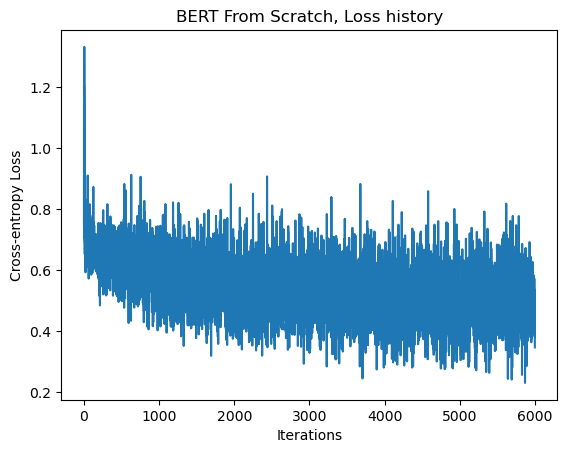

In [23]:
plt.plot(loss_history)
plt.xlabel('Iterations')
plt.ylabel('Cross-entropy Loss')
plt.title('BERT From Scratch, Loss history')
plt.show()

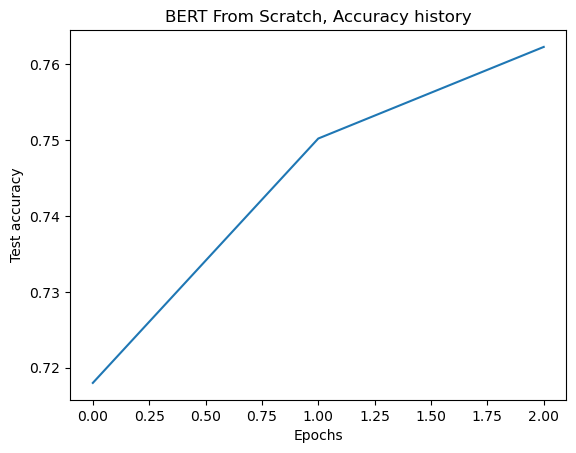

In [24]:
plt.plot(acc_history)
plt.xlabel('Epochs')
plt.ylabel('Test accuracy')
plt.title('BERT From Scratch, Accuracy history')
plt.show()